# Math 189

### Setup

In [128]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

In [129]:
# Load the data
df = pd.read_csv('capes_data.csv')
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,Percentage Recommended Class,Percentage Recommended Professor,Study Hours per Week,Average Grade Expected,Average Grade Received,Evalulation URL
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,93.5%,100.0%,2.80,A- (3.84),B+ (3.67),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,100.0%,100.0%,2.50,A- (3.86),A- (3.92),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
2,Jones Ian William Nasser,ANAR 111 - Foundations of Archaeology (A),SP23,16,3,100.0%,100.0%,3.83,B+ (3.67),NaN,https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
3,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,100.0%,83.3%,3.83,B+ (3.50),B (3.07),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
4,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,100.0%,100.0%,5.17,A (4.00),A (4.00),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...


### Data Cleaning

Since the evaluation URL does not have any influence on our result, it will be removed. In addition, we will remove the rows with missing values and update the sequence number. 

In [130]:
df = df.drop('Evalulation URL', axis=1)
df = df.drop('Instructor', axis=1)
df = df.dropna().reset_index(drop=True)

For later analysis, we will break the Average Grade Expected and Average Grade Received into letter grade and gpa and convert them into the appropriate data types.

In [131]:
#df['exp_letter'] = df['Average Grade Expected'].str.extract(r'^(\S+)')
#df['rec_letter'] = df['Average Grade Received'].str.extract(r'^(\S+)')

df['exp_gpa'] = df['Average Grade Expected'].str.extract(r'(\d+\.\d+)').astype(float)
df['rec_gpa'] = df['Average Grade Received'].str.extract(r'(\d+\.\d+)').astype(float)

df = df.drop('Average Grade Expected', axis=1)
df = df.drop('Average Grade Received', axis=1)

In [132]:
df['Quarter'] = df['Quarter'].str[0:2]
df['Quarter'] = df['Quarter'].replace(['S1', 'S2', 'S3'], 'SS')
df['Quarter'] = df['Quarter'].astype('category')


In [133]:
df['cape_prop'] = df['Total CAPEs Given']/df['Total Enrolled in Course']
df = df.drop('Total CAPEs Given', axis=1)

Some other columns will be renamed for simplicity and converted to appropriate data types.

In [134]:
df = df.rename(columns={
    'Percentage Recommended Class': 'recmd_class',
    'Percentage Recommended Professor': 'recmd_prof',
    'Study Hours per Week': 'study_hrs',
    'Total Enrolled in Course' : 'enrollment'
})

df['recmd_class'] = df['recmd_class'].str.extract(r'(\d+)').astype(float)/100
df['recmd_prof'] = df['recmd_prof'].str.extract(r'(\d+)').astype(float)/100

Now, let's take a look at the cleaned dataset.

In [135]:
df.head()

,Course,Quarter,enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,rec_gpa,cape_prop
0,AAS 10 - Intro/African-American Studies (A),SP,66,0.93,1.00,2.80,3.84,3.67,0.727273
1,AAS 170 - Legacies of Research (A),SP,20,1.00,1.00,2.50,3.86,3.92,0.350000
2,ANAR 115 - Coastal Geomorphology/Environ (A),SP,26,1.00,0.83,3.83,3.50,3.07,0.230769
3,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP,22,1.00,1.00,5.17,4.00,4.00,0.409091
4,ANBI 111 - Human Evolution (A),SP,22,1.00,1.00,2.50,4.00,2.95,0.181818


### Exploratory Data Analysis

We can obtain a general understanding of the distribution of the average grade received by drawing a histogram before further analysis.

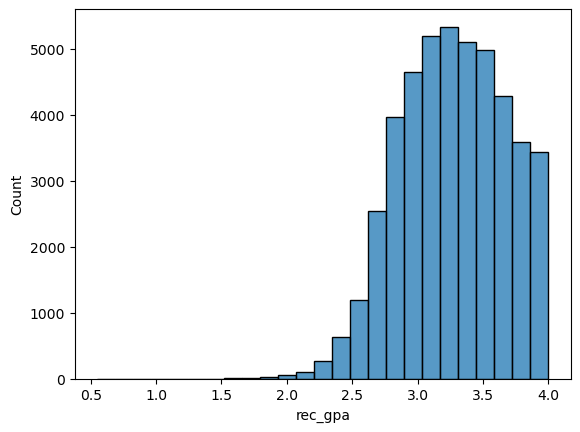

In [136]:
sns.histplot(df['rec_gpa'], bins=25)
plt.show()

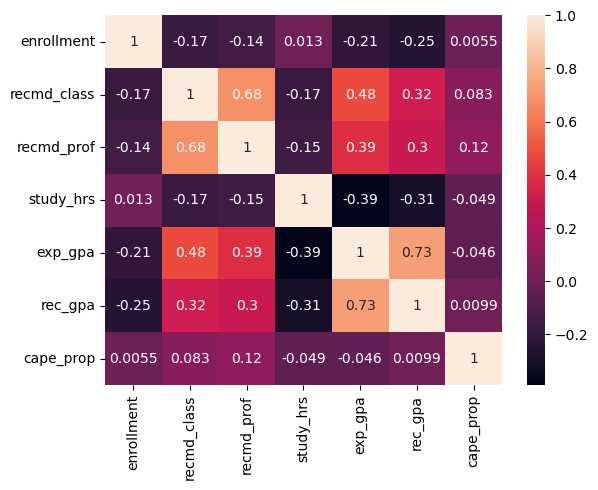

In [137]:
# Correlation
quan_data = df.drop(columns={
    #'Instructor',
    'Course',
    'Quarter',
    # 'Total Enrolled in Course',
    # 'Total CAPEs Given',
    # 'exp_letter',
    # 'rec_letter'
})
correlation_matrix = quan_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Hypothesis Testing

### Regression Analysis

In [138]:
formula = 'rec_gpa ~ Quarter + enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa+ cape_prop'
model = smf.ols(formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                rec_gpa   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     6075.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:20:57   Log-Likelihood:                -5369.6
No. Observations:               45393   AIC:                         1.076e+04
Df Residuals:                   45383   BIC:                         1.085e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0475      0.019      2.437

In [139]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
exog = model.model.exog
names = model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i):.3f}')

VIF: Quarter[T.SP]: 1.443
VIF: Quarter[T.SS]: 1.330
VIF: Quarter[T.WI]: 1.431
VIF: enrollment: 1.089
VIF: recmd_class: 2.082
VIF: recmd_prof: 1.905
VIF: study_hrs: 1.231
VIF: exp_gpa: 1.555
VIF: cape_prop: 1.071
